In [1]:
#enable API
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='/Users/varuni/Desktop/stackoverflowanalysisproject_bq_key.json'

In [2]:
#get necessary libraries
import numpy as np 
import pandas as pd 
from google.cloud import bigquery
import seaborn as sns
import matplotlib.pyplot as plt


/Users/varuni/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
client = bigquery.Client()
stackoverflow_reference = client.dataset('stackoverflow', project='bigquery-public-data')
type(stackoverflow_reference)


google.cloud.bigquery.dataset.DatasetReference

In [7]:
stackoverflow_dataset = client.get_dataset(stackoverflow_reference)

In [8]:
#get list of tables
[x.table_id for x in client.list_tables(stackoverflow_dataset)]

['badges',
 'comments',
 'post_history',
 'post_links',
 'posts_answers',
 'posts_moderator_nomination',
 'posts_orphaned_tag_wiki',
 'posts_privilege_wiki',
 'posts_questions',
 'posts_tag_wiki',
 'posts_tag_wiki_excerpt',
 'posts_wiki_placeholder',
 'stackoverflow_posts',
 'tags',
 'users',
 'votes']

In [9]:
posts_questions_tb=client.get_table(stackoverflow_dataset.table('posts_questions'))
type(posts_questions_tb)

google.cloud.bigquery.table.Table

In [10]:
#table commands
[command for command in dir(posts_questions_tb) if not command.startswith('_')]

['clustering_fields',
 'created',
 'dataset_id',
 'description',
 'encryption_configuration',
 'etag',
 'expires',
 'external_data_configuration',
 'friendly_name',
 'from_api_repr',
 'from_string',
 'full_table_id',
 'labels',
 'location',
 'modified',
 'num_bytes',
 'num_rows',
 'partition_expiration',
 'partitioning_type',
 'path',
 'project',
 'range_partitioning',
 'reference',
 'require_partition_filter',
 'schema',
 'self_link',
 'streaming_buffer',
 'table_id',
 'table_type',
 'time_partitioning',
 'to_api_repr',
 'to_bqstorage',
 'view_query',
 'view_use_legacy_sql']

In [11]:
#Exploratory Data Analysis

#Compute % of questions answered for each year
query1 = """
    SELECT
      EXTRACT(YEAR FROM creation_date) AS Year,
      COUNT(*) AS Number_of_Questions,
      SUM(IF(answer_count > 0, 1, 0)) AS Number_Questions_with_Answers,
      ROUND(100 * SUM(IF(answer_count > 0, 1, 0)) / COUNT(*), 1) AS Percent_Questions_with_Answers
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    GROUP BY Year
    ORDER BY Year
"""


In [12]:
query_job = client.query(query1)
questions_answered_df=query_job.to_dataframe()
questions_answered_df

,Year,Number_of_Questions,Number_Questions_with_Answers,Percent_Questions_with_Answers
0,2008,58015,57947,99.9
1,2009,342758,341518,99.6
2,2010,692713,686060,99.0
3,2011,1197037,1163808,97.2
4,2012,1640185,1552633,94.7
5,2013,2053755,1883686,91.7
6,2014,2156669,1911604,88.6
7,2015,2210813,1913196,86.5
8,2016,2214296,1878212,84.8
9,2017,2130398,1771434,83.2


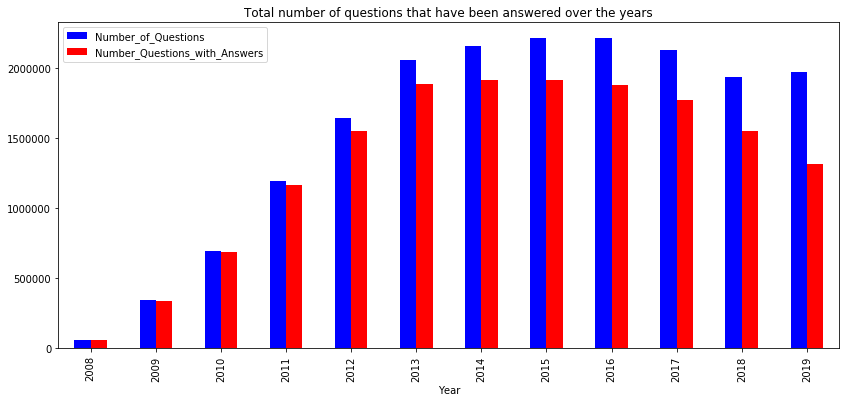

In [14]:
questions_answered_df.plot(x="Year",y=["Number_of_Questions","Number_Questions_with_Answers"], kind="bar",color=['b','r'],
                           figsize=(14,6), title='Total number of questions that have been answered over the years');

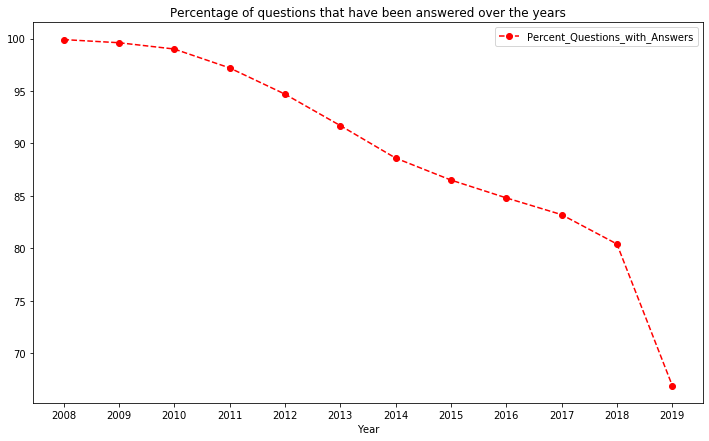

In [15]:
questions_answered_df.plot(x="Year",y="Percent_Questions_with_Answers", linestyle='--', marker='o', color='r',
                           xticks=np.arange(2008,2020,1),figsize=(12,7), title='Percentage of questions that have been answered over the years');
#We notice a 100% of questions answered at the very beginning with a low number of questions posted and then a 
#decrease in the fraction of questions answered over the years.

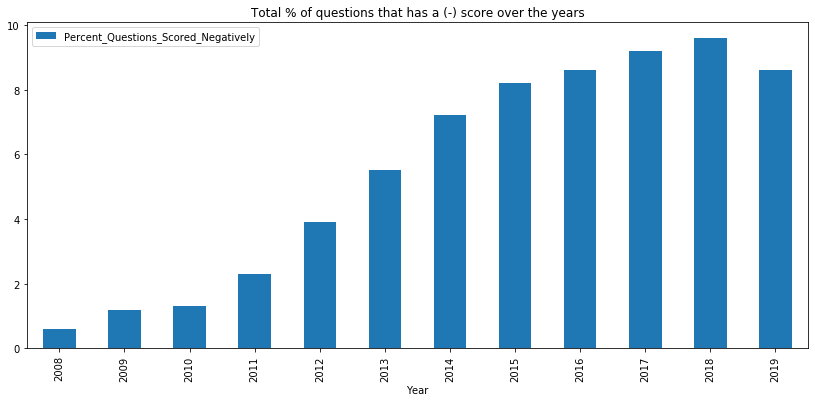

In [17]:
query2 = """SELECT EXTRACT(YEAR FROM creation_date) AS Year,
              COUNT(*) AS Number_of_Questions,
                ROUND(SUM(IF(score < 0, 1, 0))*100/COUNT(*), 1) AS Percent_Questions_Scored_Negatively
                FROM `bigquery-public-data.stackoverflow.posts_questions`
                GROUP BY Year
                ORDER BY Year"""

query_job = client.query(query2)
negative_score_df=query_job.to_dataframe()
#negative_score_df

negative_score_df.plot(x="Year",y="Percent_Questions_Scored_Negatively", kind="bar",
                           figsize=(14,6), title='Total % of questions that has a (-) score over the years');
#The fraction of negatively scored questions ave increased consisitenly over the years, with a platuea between 2017-2018 
#and a slight dip observed in 2019. 


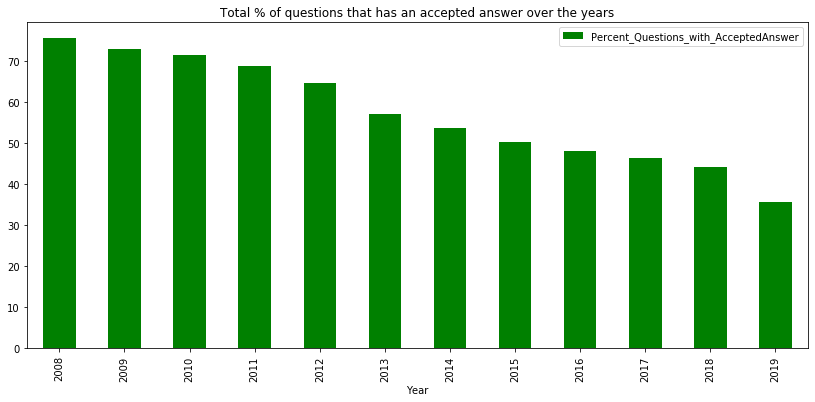

In [18]:
#What is the percentage of questions with an accepted answers over the years?
acceptedanswers_query="""
    SELECT EXTRACT(YEAR FROM creation_date) AS Year, 
        ROUND(SUM(IF(accepted_answer_id IS NOT NULL, 1, 0))*100/COUNT(*), 1) AS Percent_Questions_with_AcceptedAnswer
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    GROUP BY Year
    ORDER BY Year """
query_job = client.query(acceptedanswers_query)
acceptedanswers_df=query_job.to_dataframe()
#acceptedanswers_df
acceptedanswers_df.plot(x="Year",y="Percent_Questions_with_AcceptedAnswer", kind="bar",color='g',
                           figsize=(14,6), title='Total % of questions that has an accepted answer over the years');


In [19]:
#Top ten most popular tags 
tags_query = """
        SELECT tag,COUNT(*) count
        FROM (
              SELECT body AS question, SPLIT(tags, '|') AS tags
                FROM `bigquery-public-data.stackoverflow.posts_questions` 
            ), UNNEST(tags) tag
        GROUP BY 1
        ORDER BY 2 DESC
        LIMIT 10"""
query_job = client.query(tags_query)
popular_tags_df=query_job.to_dataframe()
popular_tags_df


,tag,count
0,javascript,1909607
1,java,1613271
2,c#,1363741
3,php,1320047
4,python,1297726
5,android,1237162
6,jquery,971418
7,html,863493
8,c++,644513
9,ios,615317


In [20]:
#get the length of questions for the most popular tags
#run a parameterized query to get the questions for the most popular tags

tags_list=popular_tags_df['tag'].values.tolist()
print(tags_list)
question_length_query="""
        SELECT tag, question
        FROM (
              SELECT body AS question, SPLIT(tags, '|') AS tags
                FROM `bigquery-public-data.stackoverflow.posts_questions` 
            ), UNNEST(tags) tag  
        WHERE tag IN UNNEST(@tagnames)
        LIMIT 5000"""

job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("tagnames", "STRING", tags_list),
    ]
)


['javascript', 'java', 'c#', 'php', 'python', 'android', 'jquery', 'html', 'c++', 'ios']


In [21]:
query_job = client.query(question_length_query, job_config=job_config)

In [22]:
question_length_df=query_job.to_dataframe()
question_length_df.head()

,tag,question
0,java,<p><br>\nI have a JScrollPane which needs to b...
1,c++,<p>When I run the program I get a segmentation...
2,ios,<p>How the get the information of the apple ch...
3,c#,<p>I'm wondering what's the best way to perfor...
4,ios,<p>I created a QuickBlox QBChatDialog as shown...


In [23]:
question_length_df.loc[:,'length_of_question'] = question_length_df.loc[:,'question'].apply(len)

In [24]:
question_length_df.head(10)

,tag,question,length_of_question
0,java,<p><br>\nI have a JScrollPane which needs to b...,1997
1,c++,<p>When I run the program I get a segmentation...,2267
2,ios,<p>How the get the information of the apple ch...,136
3,c#,<p>I'm wondering what's the best way to perfor...,753
4,ios,<p>I created a QuickBlox QBChatDialog as shown...,1745
5,android,<p>I have a problem. I checked a lot of stacko...,2307
6,python,<p>I am currently working with pxssh for Pytho...,614
7,java,<p>Is it possible to get the <code>emailable-r...,329
8,ios,"<p>I am trying to start testing my app, and so...",1127
9,python,<p>Is there any package (not win32 for windows...,593


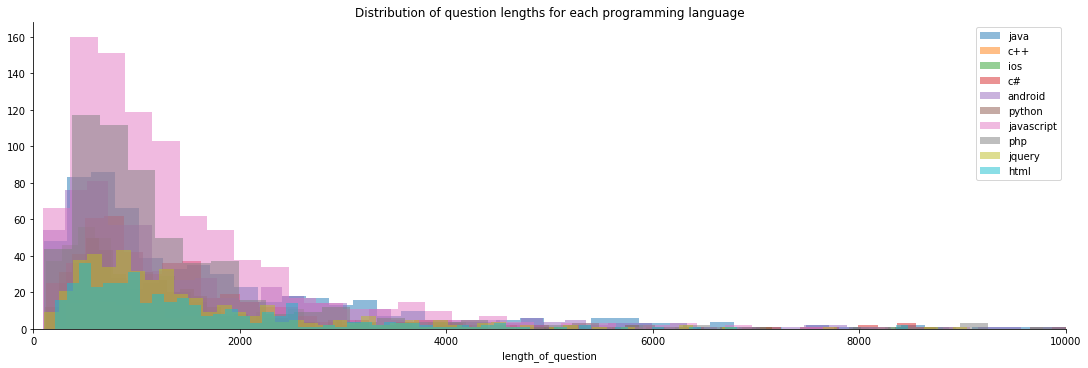

In [25]:
grid = sns.FacetGrid(question_length_df, hue = 'tag', height = 5, aspect = 3)
grid.map(plt.hist, 'length_of_question', bins = 100, alpha = 0.5)
axes = grid.axes

axes[0,0].set_title('Distribution of question lengths for each programming language')
axes[0,0].set_xlim([0,10000])
axes[0,0].legend()

In [26]:
#Top ten easiest gold badges to earn 

badges_query= """
        SELECT name, COUNT(user_id) AS count
        FROM `bigquery-public-data.stackoverflow.badges` 
        WHERE class=1 --1=gold 2=silver 3=bronze 
        GROUP BY name
        ORDER BY count DESC
        LIMIT 10

"""

query_job = client.query(badges_query)
badges_df=query_job.to_dataframe()
badges_df

,name,count
0,Famous Question,690609
1,Great Answer,80413
2,Great Question,37455
3,Fanatic,33911
4,Unsung Hero,22523
5,Electorate,21824
6,Populist,21587
7,Steward,14461
8,Stellar Question,7936
9,Publicist,6930


In [27]:
query3="""SELECT (
  COUNT(case when title like '%?' then 1 end) / 
  COUNT(*)
  ) * 100 as percent_questions 
FROM 
  `bigquery-public-data.stackoverflow.posts_questions`"""

query_job = client.query(query3)
ends_with_df=query_job.to_dataframe()
ends_with_df

,percent_questions
0,21.539525


The following data was extractedfrom Google BigQuery using the following SQL query.

WITH answers AS ( SELECT * , REGEXP_EXTRACT(LOWER(title), '[a-z]+') first_word , '?' = SUBSTR(title, LENGTH(title)) ends_question , GREATEST(1, TIMESTAMP_DIFF(answers.first, creation_date, minute)) minutes_first_answer , answers.c > 0 was_answered FROM ( SELECT creation_date, title , CASE WHEN LENGTH(body)<700 THEN 'short' WHEN LENGTH(body)<1700 THEN 'medium' ELSE 'long' END question_length , (SELECT AS STRUCT MIN(creation_date) first, COUNT() c FROM bigquery-public-data.stackoverflow.posts_answers WHERE a.id=parent_id ) answers ,(SELECT AS STRUCT EXTRACT(year FROM creation_date) account_creation_year FROM bigquery-public-data.stackoverflow.users
WHERE a.owner_user_id=id ) user , SPLIT(tags, '|') tags FROM bigquery-public-data.stackoverflow.posts_questions a ) ) SELECT first_word, ends_question, tag, FORMAT_TIMESTAMP('%H', creation_date) hour_utc, FORMAT_TIMESTAMP('%A', creation_date) weekday_utc, user.account_creation_year,question_length, EXP(AVG(LOG(minutes_first_answer ))) time_to_answer, COUNT(minutes_first_answer)/COUNT() chance_of_answer, COUNT(*) questions FROM answers, UNNEST(tags) tag WHERE tag IN ('python', 'r','mysql', 'machine-learning','data-science') AND first_word IN UNNEST(['how','is','why','what','can', 'i']) GROUP BY 1,2,3,4,5,6,7

In [28]:
file_path = 'bq-results-2.csv'
data = pd.read_csv(file_path)
data.head()

,first_word,ends_question,tag,hour_utc,weekday_utc,account_creation_year,question_length,time_to_answer,chance_of_answer,questions
0,is,True,python,0,Wednesday,2017.0,short,18.507713,1.0,5
1,why,True,python,0,Monday,2014.0,short,3.556893,1.0,3
2,what,True,python,0,Saturday,2018.0,medium,3.000000,0.5,2
3,how,False,python,0,Friday,2011.0,medium,13.153723,0.8,10
4,why,True,python,0,Sunday,2019.0,medium,26.560366,1.0,4


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69174 entries, 0 to 69173
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   first_word             69174 non-null  object 
 1   ends_question          69174 non-null  bool   
 2   tag                    69174 non-null  object 
 3   hour_utc               69174 non-null  int64  
 4   weekday_utc            69174 non-null  object 
 5   account_creation_year  66575 non-null  float64
 6   question_length        69174 non-null  object 
 7   time_to_answer         60484 non-null  float64
 8   chance_of_answer       69174 non-null  float64
 9   questions              69174 non-null  int64  
dtypes: bool(1), float64(3), int64(2), object(4)
memory usage: 4.8+ MB


In [30]:
# check the column-wise distribution of null values:
data.isnull().sum()

first_word                  0
ends_question               0
tag                         0
hour_utc                    0
weekday_utc                 0
account_creation_year    2599
question_length             0
time_to_answer           8690
chance_of_answer            0
questions                   0
dtype: int64

In [31]:
data.dropna(inplace=True)

In [32]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58193 entries, 0 to 69173
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   first_word             58193 non-null  object 
 1   ends_question          58193 non-null  bool   
 2   tag                    58193 non-null  object 
 3   hour_utc               58193 non-null  int64  
 4   weekday_utc            58193 non-null  object 
 5   account_creation_year  58193 non-null  float64
 6   question_length        58193 non-null  object 
 7   time_to_answer         58193 non-null  float64
 8   chance_of_answer       58193 non-null  float64
 9   questions              58193 non-null  int64  
dtypes: bool(1), float64(3), int64(2), object(4)
memory usage: 4.5+ MB


first_word               0
ends_question            0
tag                      0
hour_utc                 0
weekday_utc              0
account_creation_year    0
question_length          0
time_to_answer           0
chance_of_answer         0
questions                0
dtype: int64

In [33]:
data['account_creation_year']=data['account_creation_year'].astype(int)
data.dtypes

first_word                object
ends_question               bool
tag                       object
hour_utc                   int64
weekday_utc               object
account_creation_year      int64
question_length           object
time_to_answer           float64
chance_of_answer         float64
questions                  int64
dtype: object

In [34]:
data.describe()

,hour_utc,account_creation_year,time_to_answer,chance_of_answer,questions
count,58193.000000,58193.000000,5.819300e+04,58193.000000,58193.000000
mean,11.973433,2015.412129,5.493340e+03,0.887347,4.165432
std,6.596864,2.809251,5.026316e+04,0.181915,6.716489
min,0.000000,2008.000000,1.000000e+00,0.125000,1.000000
25%,7.000000,2013.000000,1.200000e+01,0.800000,1.000000
50%,12.000000,2016.000000,3.500000e+01,1.000000,2.000000
75%,18.000000,2018.000000,1.377351e+02,1.000000,4.000000
max,23.000000,2019.000000,1.475224e+06,1.000000,74.000000


In [35]:
#categorical data
data.question_length.value_counts(normalize=True)

medium    0.378190
short     0.345127
long      0.276683
Name: question_length, dtype: float64

In [36]:
data.weekday_utc.value_counts(normalize=True)

Wednesday    0.157613
Thursday     0.156565
Tuesday      0.154709
Friday       0.150860
Monday       0.146048
Saturday     0.117488
Sunday       0.116715
Name: weekday_utc, dtype: float64

In [37]:
data.tag.value_counts(normalize=True)

python              0.496864
mysql               0.224563
r                   0.192257
machine-learning    0.073187
data-science        0.013129
Name: tag, dtype: float64

In [38]:
bytag_length=data.groupby("tag").question_length.value_counts(normalize=True)
bytag_length

tag               question_length
data-science      short              0.418848
                  medium             0.388743
                  long               0.192408
machine-learning  short              0.378493
                  medium             0.365814
                  long               0.255694
mysql             medium             0.380242
                  short              0.335399
                  long               0.284359
python            medium             0.372622
                  short              0.349900
                  long               0.277478
r                 medium             0.394172
                  short              0.326421
                  long               0.279407
Name: question_length, dtype: float64

In [39]:
byyear_tag=data.groupby("account_creation_year").tag.value_counts(normalize=True)
byyear_tag


account_creation_year  tag             
2008                   python              0.776087
                       mysql               0.115217
                       r                   0.093478
                       machine-learning    0.015217
2009                   python              0.679908
                       r                   0.165011
                       mysql               0.129106
                       machine-learning    0.025210
                       data-science        0.000764
2010                   python              0.647089
                       mysql               0.180353
                       r                   0.129938
                       machine-learning    0.038462
                       data-science        0.004158
2011                   python              0.584791
                       mysql               0.203903
                       r                   0.157133
                       machine-learning    0.048789
                       d

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55283 entries, 0 to 69172
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   first_word             55283 non-null  object 
 1   ends_question          55283 non-null  bool   
 2   tag                    55283 non-null  object 
 3   hour_utc               55283 non-null  int64  
 4   weekday_utc            55283 non-null  object 
 5   account_creation_year  55283 non-null  int64  
 6   question_length        55283 non-null  object 
 7   time_to_answer         55283 non-null  float64
 8   chance_of_answer       55283 non-null  float64
 9   questions              55283 non-null  int64  
dtypes: bool(1), float64(2), int64(3), object(4)
memory usage: 4.3+ MB


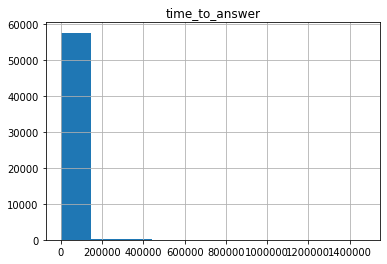

<Figure size 432x288 with 0 Axes>

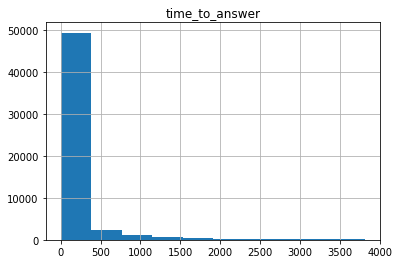

In [40]:
# Find the 95th quantile
quantile = data['time_to_answer'].quantile(0.95)

# Trim the outliers
trimmed_df= data[data['time_to_answer'] < quantile]

trimmed_df.info()

# The original histogram
data[['time_to_answer']].hist()
plt.show()
plt.clf()

# The trimmed histogram
trimmed_df[['time_to_answer']].hist()
plt.show()

#ideally, feature scaling and outlier handling, should be done ONLY on the training data in order to avoid data leakage!
#Right skewed

In [42]:
#one-hot encode categorical values

# Categorical boolean mask
categorical_feature_mask = trimmed_df.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = trimmed_df.columns[categorical_feature_mask].tolist()
print(categorical_cols)
cat_columns_idx = [trimmed_df.columns.get_loc(col) for col in categorical_cols]
print(cat_columns_idx)

['first_word', 'tag', 'weekday_utc', 'question_length']
[0, 2, 4, 6]


In [43]:
#Dealing with uncommon categories

first_words = trimmed_df['first_word']
# Get the counts of each category
first_word_counts = first_words.value_counts()
print('first_word_counts\n',first_word_counts,'\n')

tags = trimmed_df['tag']
# Get the counts of each category
tag_counts = tags.value_counts()
print('tag\n',tag_counts,'\n')

weekdays = trimmed_df['weekday_utc']
# Get the counts of each category
weekdays_counts = weekdays.value_counts()
print('tag\n',weekdays_counts,'\n')

question_lengths = trimmed_df['question_length']
# Get the counts of each category
question_length_counts = question_lengths.value_counts()
print('question_length\n',question_length_counts,'\n')

first_word_counts
 how     26610
why      7779
is       6157
what     5776
can      5100
i        3861
Name: first_word, dtype: int64 

tag
 python              27650
mysql               12624
r                   10596
machine-learning     3723
data-science          690
Name: tag, dtype: int64 

tag
 Wednesday    8752
Thursday     8641
Tuesday      8548
Friday       8276
Monday       8087
Saturday     6496
Sunday       6483
Name: weekday_utc, dtype: int64 

question_length
 medium    21005
short     19263
long      15015
Name: question_length, dtype: int64 



In [44]:
# Perform one-hot encode by using the get_dummies function

one_hot_encoded =pd.get_dummies(trimmed_df, columns=categorical_cols,prefix='C')
#print(dummies.head())
#df_concat=pd.concat([data,dummies],axis=1)
#df_processed=df_concat.drop(data[categorical_cols], axis=1)
print(one_hot_encoded.head())
print(one_hot_encoded.columns)
one_hot_encoded.info()

   ends_question  hour_utc  account_creation_year  time_to_answer  \
0           True         0                   2017       18.507713   
1           True         0                   2014        3.556893   
2           True         0                   2018        3.000000   
3          False         0                   2011       13.153723   
4           True         0                   2019       26.560366   

   chance_of_answer  questions  C_can  C_how  C_i  C_is  ...  C_Friday  \
0               1.0          5      0      0    0     1  ...         0   
1               1.0          3      0      0    0     0  ...         0   
2               0.5          2      0      0    0     0  ...         0   
3               0.8         10      0      1    0     0  ...         1   
4               1.0          4      0      0    0     0  ...         0   

   C_Monday  C_Saturday  C_Sunday  C_Thursday  C_Tuesday  C_Wednesday  C_long  \
0         0           0         0           0          0   

In [59]:
# initialize a score table to log the performance of various algorithms
index = ['LinearRegression','Lasso','Ridge','DecisionTreeRegressor','RandomForestRegressor','AdaBoostRegressor','GradientBoostingRegressor']
score_table = pd.DataFrame(index = index, columns= ['r2_train','r2_test','mse_train','mse_test'])

In [60]:
#Function to compute and plot results
def plot_result(model_name, pred_train, pred_test):
    """compute, log and plot the performance for both training and test sets"""
    
    # compute the performance
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)
    mse_train = MSE(y_train, pred_train)
#    rmse_train=np.sqrt(mse_train)
    mse_test = MSE(y_test, pred_test)
#    rmse_test=np.sqrt(mse_test)
    
#print("Test set RMSE with Linear Regression: {:,.3f}".format(rmse))

    # log the performance
    score_table.loc[model_name,:] = r2_train, r2_test, mse_train, mse_test
    
    # plot the predicted values vs actual for both training and test sets
    fig = plt.figure(figsize=(18,5))

    ax1 = fig.add_subplot(121) # plot training set vs prediction
    ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
    ax1.plot(X_train.index, pred_train, color='red',alpha=0.5);
    ax1.set_xlim([X_train.index[0],X_train.index[500]]); 
    ax1.set_xlabel('First 500 points of the training set');
    ax1.set_ylabel('Time to answer');
    ax1.legend(['actual','predicted']);
    ax1.set_title('Training set: R2={:.2f}, MSE={:.2f}'.format(r2_train, mse_train));

    ax2 = fig.add_subplot(122) # plot test set vs prediction
    ax2.plot(X_test.index, y_test, color='blue',alpha=0.5);
    ax2.plot(X_test.index, pred_test, color='red',alpha=0.5);
    ax2.set_xlim([X_test.index[-500],X_test.index[-1]]); 
    ax2.set_xlabel('Last 500 points of the test set');
    ax2.set_ylabel('Time to answer');
    ax2.legend(['actual','predicted']);
    ax2.set_title('Test set: R2={:.2f}, MSE={:.2f}'.format(r2_test, mse_test));

In [61]:
y = np.log(one_hot_encoded['time_to_answer'])
X=one_hot_encoded[one_hot_encoded.columns.difference(['time_to_answer'])]

In [62]:
# Split into test and training data
from sklearn.model_selection import train_test_split
#train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1) #specify %
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
print(len(X_train), len(y_train))
print(len(X_test),len(y_test))
#reset indices
X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

44226 44226
11057 11057


                  feature   coefficient
12                 C_long  8.472646e+11
14               C_medium  8.472646e+11
18                C_short  8.472646e+11
9                   C_how  4.475242e+11
11                   C_is  4.475242e+11
7                   C_can  4.475242e+11
10                    C_i  4.475242e+11
19                 C_what  4.475242e+11
20                  C_why  4.475242e+11
2              C_Saturday  1.181243e+11
3                C_Sunday  1.181243e+11
1                C_Monday  1.181243e+11
4              C_Thursday  1.181243e+11
5               C_Tuesday  1.181243e+11
6             C_Wednesday  1.181243e+11
0                C_Friday  1.181243e+11
25              questions  2.641510e-01
22       chance_of_answer  6.262326e-02
23          ends_question  6.150198e-02
24               hour_utc -1.418905e-01
21  account_creation_year -2.528181e-01
13     C_machine-learning -4.423876e+11
8          C_data-science -4.423876e+11
17                    C_r -4.423876e+11


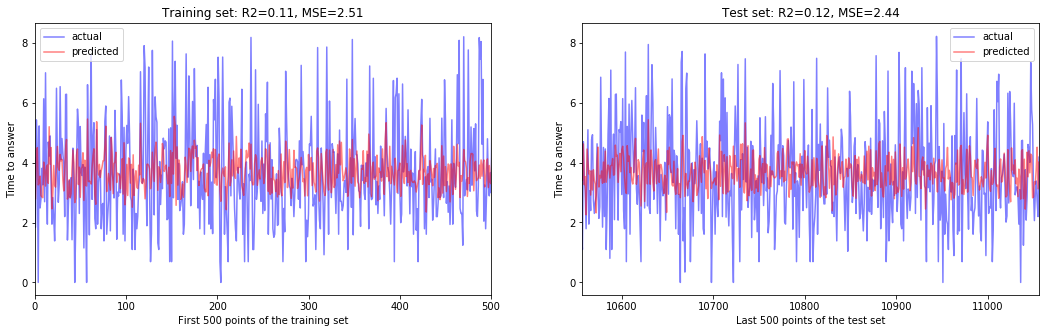

In [63]:
# we will be only appying linear and tree-based regression models as all other methods assume normal distribution and require all features to be on the same scale. 

#linear Regression model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


#instatiate model
#lr_model = linear_model.LinearRegression()
#Feature scaling must be only done after rtain/test splitting to avoid data leakage
lr_model = Pipeline([('scaler', MinMaxScaler()),('lr_model',LinearRegression())])
lr_model.fit(X_train, y_train)

train_pred = lr_model.predict(X_train)
test_pred = lr_model.predict(X_test)
plot_result('LinearRegression', train_pred, test_pred)

feature_rank = pd.DataFrame({'feature':X_train.columns, 'coefficient':lr_model.named_steps.lr_model.coef_})
print(feature_rank.sort_values('coefficient',ascending=False))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished


Best hyperparameters: {'lasso__alpha': 0.01}
Best model: Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('lasso',
                 Lasso(alpha=0.01, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)
Corresponding score: -2.5299219562832422
C_machine-learning       0.716818
C_long                   0.582344
C_how                    0.232756
C_Saturday               0.088633
ends_question            0.035867
C_is                     0.035160
C_Sunday                 0.033437
C_can                    0.008368
C_Monday                 0.000000
C_Thursday              -0.000000
C_Tuesday               -0.000000
C_Wednesday             -0.000000
C_data-science           0.000000
questions               -0.000000
C_me

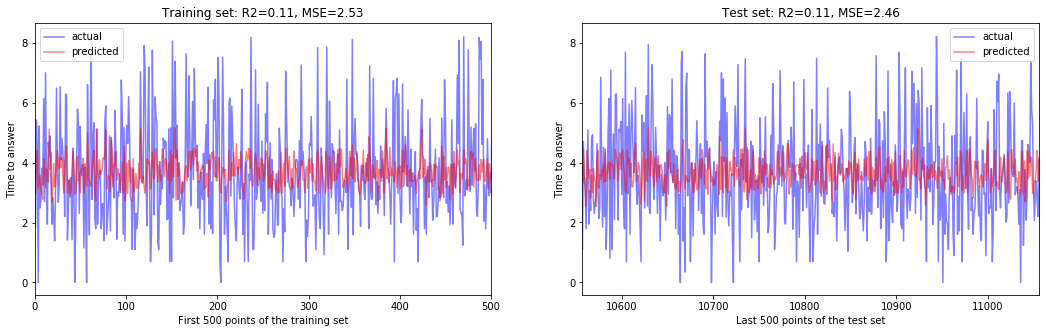

In [64]:
# LASSO
from sklearn.linear_model import Lasso

lasso= Pipeline([('scaler', MinMaxScaler()),('lasso',Lasso())])

# grid search of parameter alpha to improve lasso model
parameters = {'lasso__alpha': np.arange(0.01, 1, 0.05)}
lasso_cv = GridSearchCV(estimator=lasso, param_grid=parameters, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
lasso_cv.fit(X_train, y_train)

#Extract the best estimators
best_hyperparameters=lasso_cv.best_params_
print('Best hyperparameters:',best_hyperparameters)
best_model = lasso_cv.best_estimator_
print('Best model:',best_model)
print('Corresponding score:', lasso_cv.best_score_)

pred_train = lasso_cv.predict(X_train)
pred_test = lasso_cv.predict(X_test)
plot_result('Lasso', pred_train, pred_test)

#Feature importances
feature_rank = pd.Series(data=lasso_cv.best_estimator_.named_steps.lasso.coef_, index= X_train.columns)
feature_rank_sorted = feature_rank.sort_values(ascending=False)
print(feature_rank_sorted)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished


Best hyperparameters: {'ridge__alpha': 7000}
Best model: Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('ridge',
                 Ridge(alpha=7000, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)
Corresponding score: -2.5956448537998638
C_long                   0.361045
C_machine-learning       0.263673
C_how                    0.172093
C_Saturday               0.066284
ends_question            0.048342
C_Sunday                 0.042255
C_r                      0.038240
C_is                     0.028830
C_can                    0.028027
chance_of_answer         0.017947
C_data-science           0.015620
questions               -0.000943
C_Monday                -0.002232
C_Thursday              -0.022125
C_Wednesday             -0.025163
C_Tuesday               -0.028472
C_Friday         

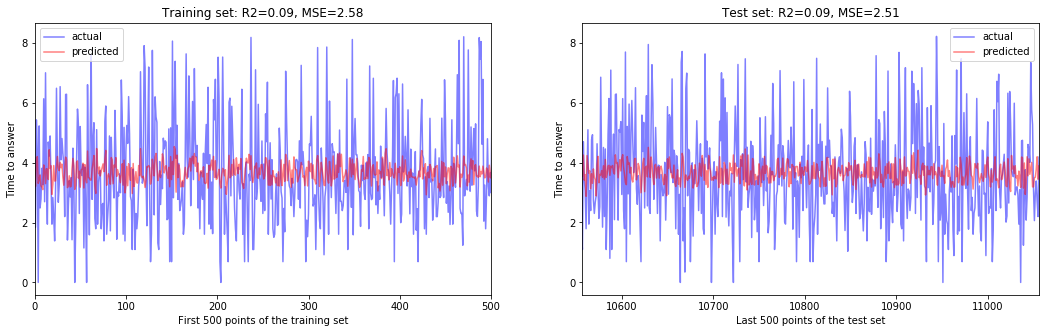

In [66]:
# RIDGE
from sklearn.linear_model import Ridge

ridge= Pipeline([('scaler', MinMaxScaler()),('ridge',Ridge())])

# grid search of parameter alpha to improve lasso model
parameters = {'ridge__alpha': np.arange(7000, 9000, 100)}
ridge_cv = GridSearchCV(estimator=ridge, param_grid=parameters, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
ridge_cv.fit(X_train, y_train)

#Extract the best estimators
best_hyperparameters=ridge_cv.best_params_
print('Best hyperparameters:',best_hyperparameters)
best_model = ridge_cv.best_estimator_
print('Best model:',best_model)
print('Corresponding score:', ridge_cv.best_score_)

pred_train = ridge_cv.predict(X_train)
pred_test = ridge_cv.predict(X_test)
plot_result('Ridge', pred_train, pred_test)

#feature_rank = pd.DataFrame({'feature':X_train.columns, 'coefficient':lasso.named_steps.lasso.coef_})
#print(feature_rank.sort_values('coefficient',ascending=False))

#Feature importances
feature_rank = pd.Series(data=ridge_cv.best_estimator_.named_steps.ridge.coef_, index= X_train.columns)
feature_rank_sorted = feature_rank.sort_values(ascending=False)
print(feature_rank_sorted)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    8.7s finished


Best hyperparameters: {'dt_model__max_features': 'auto', 'dt_model__max_leaf_nodes': 150, 'dt_model__min_samples_leaf': 50}
Best model: Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('dt_model',
                 DecisionTreeRegressor(criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=150,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=50, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort=False, random_state=1,
                                       splitter='best'))],
         verbose=False)
Corresponding score: -2.5176835247695912
C_long                   0.331117
C_machine-learning       0.157824
C_mysql                  0.108888
C_short   

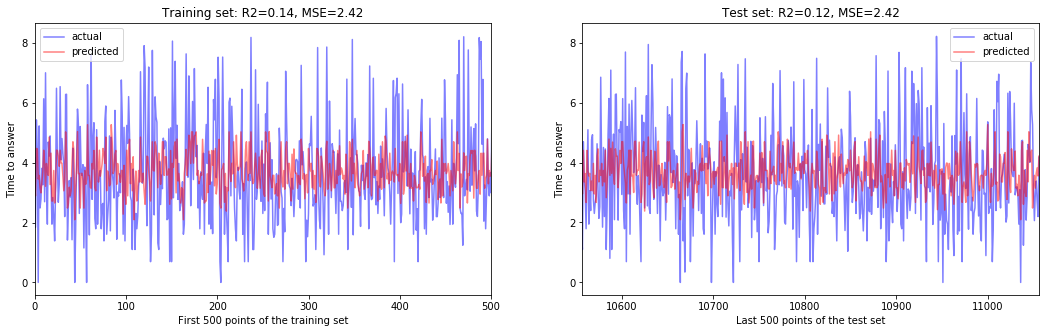

In [68]:
#decision tree model
from sklearn.tree import DecisionTreeRegressor

# Specify Model
dt_model = Pipeline([('scaler', MinMaxScaler()),('dt_model',DecisionTreeRegressor(random_state=1))])
#Hyper-parameter tuning and 5-fold cross-validation
params_dt = {'dt_model__max_leaf_nodes': [150, 250, 300],'dt_model__max_features': ['log2', 'auto', 'sqrt'],'dt_model__min_samples_leaf': [10, 30, 50]}
grid_dt=GridSearchCV(estimator=dt_model, param_grid=params_dt, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)


grid_dt.fit(X_train, y_train)

#Extract the best estimators
best_hyperparameters=grid_dt.best_params_
print('Best hyperparameters:',best_hyperparameters)
best_model = grid_dt.best_estimator_
print('Best model:',best_model)
print('Corresponding score:', grid_dt.best_score_)

#Predict and plot
train_pred = grid_dt.predict(X_train)
test_pred = grid_dt.predict(X_test)
plot_result('DecisionTreeRegressor', train_pred, test_pred)

#Feature importances
feature_rank = pd.Series(data=grid_dt.best_estimator_.named_steps.dt_model.feature_importances_, index= X_train.columns)
feature_rank_sorted = feature_rank.sort_values(ascending=False)
print(feature_rank_sorted)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  4.7min finished


Best hyperparameters: {'rf_model__max_features': 'sqrt', 'rf_model__min_samples_leaf': 30, 'rf_model__n_estimators': 300}
Best model: Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('rf_model',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='sqrt',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=30, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=300, n_jobs=None,
                                       oob_score=False, random_state=1,
                                       verbose=0, warm_start=False))],
         verbose=False)
Corresponding s

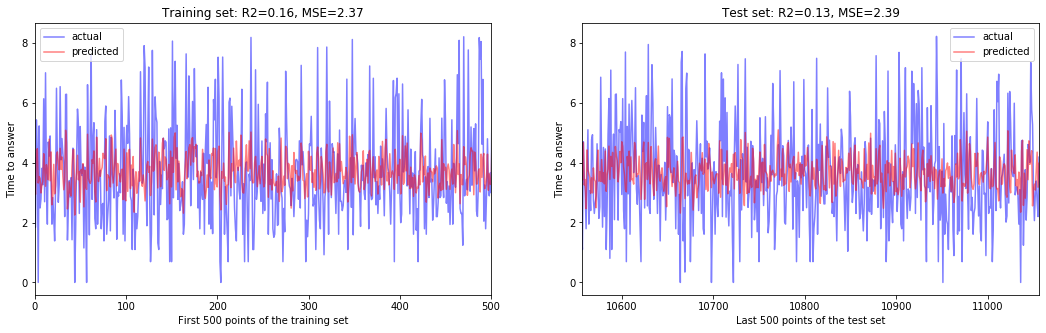

In [70]:
# Ensemble Learning 1
#Bagging (bootstrap sampling-draw with replacement with same algorithm)

from sklearn.ensemble import RandomForestRegressor
    
#Instantiate model
rf_model = Pipeline([('scaler', MinMaxScaler()),('rf_model',RandomForestRegressor(random_state=1))])
#Hyper-parameter tuning and 5-fold cross-validation
params_rf = {'rf_model__n_estimators': [100, 200, 300],'rf_model__max_features': ['log2', 'auto', 'sqrt'],'rf_model__min_samples_leaf': [10, 30, 50]}
grid_rf=GridSearchCV(estimator=rf_model, param_grid=params_rf, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

#Fit
grid_rf.fit(X_train, y_train)

#Extract the best estimators
best_hyperparameters=grid_rf.best_params_
print('Best hyperparameters:',best_hyperparameters)
best_model = grid_rf.best_estimator_
print('Best model:',best_model)
print('Corresponding score:', grid_rf.best_score_)

#Predict and plot
train_pred = grid_rf.predict(X_train)
test_pred = grid_rf.predict(X_test)
plot_result('RandomForestRegressor', train_pred, test_pred)

#Feature importances
feature_rank = pd.Series(data=grid_rf.best_estimator_.named_steps.rf_model.feature_importances_, index= X_train.columns)
feature_rank_sorted = feature_rank.sort_values(ascending=False)
print(feature_rank_sorted)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   30.5s finished


Best hyperparameters: {'ada_model__learning_rate': 0.001, 'ada_model__n_estimators': 50}
Best model: Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('ada_model',
                 AdaBoostRegressor(base_estimator=None, learning_rate=0.001,
                                   loss='linear', n_estimators=50,
                                   random_state=1))],
         verbose=False)
Corresponding score: -2.560412309128974
C_long                   0.495266
C_machine-learning       0.226725
C_short                  0.131396
C_mysql                  0.098992
C_how                    0.038452
hour_utc                 0.006831
account_creation_year    0.000552
C_Sunday                 0.000420
chance_of_answer         0.000398
C_Thursday               0.000220
C_i                      0.000167
C_is                     0.000152
C_Friday                 0.000145
C_Saturday               0.000093
C_Wednesday              0.000088


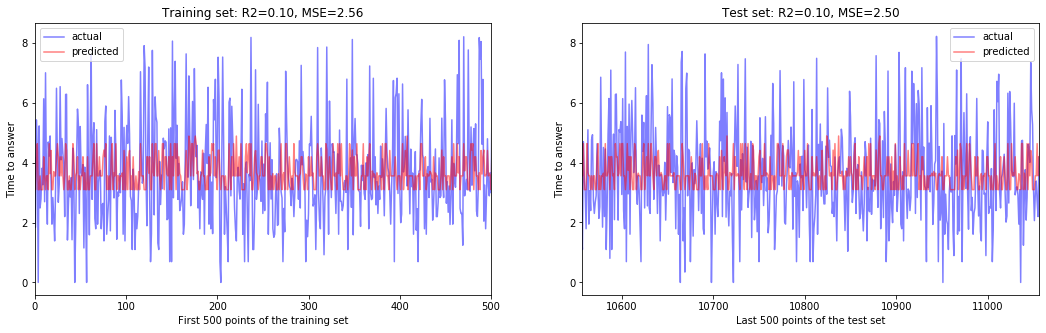

In [72]:
# Ensemble Learning 2: Adaboost(Adaptive Boosting)
#Boosting (combining weak learners to form a strong learner)
#1) ensemble of predictors are trained sequentially
#2) each predictor tries to correct its predecessor

from sklearn.ensemble import AdaBoostRegressor

ada_model = Pipeline([('scaler', MinMaxScaler()),('ada_model',AdaBoostRegressor(random_state=1))])

#Hyper-parameter tuning and 5-fold cross-validation
params_ada = {'ada_model__n_estimators': [10, 20, 50],'ada_model__learning_rate': [0.001, 0.01, 0.1]}
grid_ada=GridSearchCV(estimator=ada_model, param_grid=params_ada, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

#Fit
grid_ada.fit(X_train, y_train)

#Extract the best estimators
best_hyperparameters=grid_ada.best_params_
print('Best hyperparameters:',best_hyperparameters)
best_model = grid_ada.best_estimator_
print('Best model:',best_model)
print('Corresponding score:', grid_ada.best_score_)

#Predict and plot
train_pred = grid_ada.predict(X_train)
test_pred = grid_ada.predict(X_test)
plot_result('AdaBoostRegressor', train_pred, test_pred)

#Feature importances
feature_rank = pd.Series(data=grid_ada.best_estimator_.named_steps.ada_model.feature_importances_, index= X_train.columns)
feature_rank_sorted = feature_rank.sort_values(ascending=False)
print(feature_rank_sorted)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 29.0min finished


Best hyperparameters: {'gb_model__learning_rate': 0.1, 'gb_model__max_depth': 2, 'gb_model__min_samples_leaf': 100, 'gb_model__n_estimators': 300}
Best model: Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('gb_model',
                 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse',
                                           init=None, learning_rate=0.1,
                                           loss='ls', max_depth=2,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=100,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                             

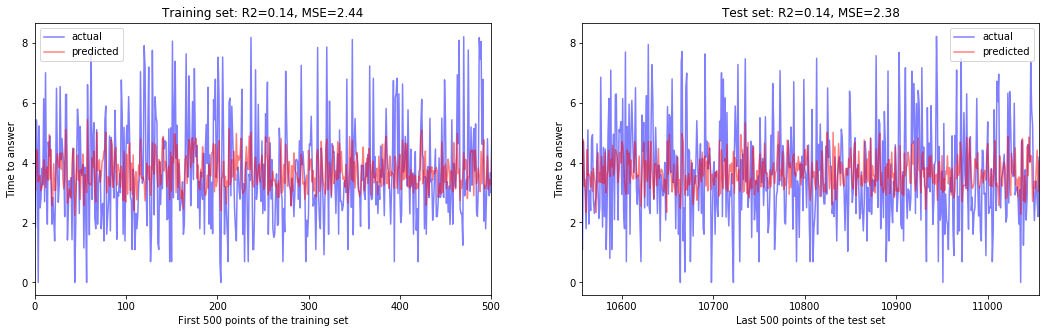

In [74]:
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate gb
gb_model = Pipeline([('scaler', MinMaxScaler()),('gb_model',GradientBoostingRegressor(random_state=1))])

#Hyper-parameter tuning and 5-fold cross-validation
params_gb = {'gb_model__n_estimators': [100, 200, 300],'gb_model__max_depth': [2,4,6],'gb_model__min_samples_leaf': [1, 50, 100],'gb_model__learning_rate': [0.01,0.1,1.0]}
grid_gb=GridSearchCV(estimator=gb_model, param_grid=params_gb, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

grid_gb.fit(X_train, y_train)

#Extract the best estimators
best_hyperparameters=grid_gb.best_params_
print('Best hyperparameters:',best_hyperparameters)
best_model = grid_gb.best_estimator_
print('Best model:',best_model)
print('Corresponding score:', grid_gb.best_score_)


train_pred = grid_gb.predict(X_train)
test_pred = grid_gb.predict(X_test)
plot_result('GradientBoostingRegressor', train_pred, test_pred)

#Feature importances
feature_rank = pd.Series(data=grid_gb.best_estimator_.named_steps.gb_model.feature_importances_, index= X_train.columns)
feature_rank_sorted = feature_rank.sort_values(ascending=False)
print(feature_rank_sorted)

In [75]:
print(score_table)

                            r2_train    r2_test mse_train mse_test
LinearRegression            0.112513   0.115753   2.51319  2.44304
Lasso                       0.107216   0.110074   2.52819  2.45873
Ridge                      0.0890805  0.0907337   2.57955  2.51216
DecisionTreeRegressor       0.144187   0.122418    2.4235  2.42462
RandomForestRegressor       0.164307   0.133187   2.36652  2.39487
AdaBoostRegressor          0.0963932  0.0962868   2.55884  2.49682
GradientBoostingRegressor   0.138721   0.137741   2.43898  2.38229
